PHY5340 Laboratory 6: Finite Differences

Jeremiah O'Neil, SN6498391

---

# Finite Differences for Eigenvalues and Eigenfunctions

In [1]:
newV = @(pars) (@(x) pars(1)*x.^2 + pars(2)*x.^3 + pars(3)*x.^4);

I've adapted a finite-difference time-independent Schroedinger equation BVP solver from C16_3; it creates a grid between (including) endpoints $x_0$ and $x_1$ with $N$ points (separated by the corresponding even spacing $h$) and returns the first $numret$ eigenvalues and normalized eigenfunctions after $Ne$ Lanczos iterations.

In [2]:
type('tise_fd.m')

tise_fd.m is the user-defined function defined from: /home/jer/Projects/PHY5340/labs/L6/tise_fd.m

function [eigE, eigfuncs, x] = tise_fd(V, x0, xend, N, Ne, numret)
%finite differences for time-independent schroedinger equation
%adapted from C16_3
% assuming psi(x0) = 0 = psi(xend)
m2_hsqr = 2 / 0.076199682;  % eV^-1 nm^-2

% linspace is the most reliable way to make N evenly spaced points.
% Jacob's code in C16_3 would be wrong for non-integer x0 and xend
x = linspace(x0, xend, N+2);
x = x(2:end-1);
h = x(2) - x(1);

% I'll generate the sparse matrix directly for efficiency
offdiag = -1/h^2 * ones(1,N-1);
diags = [offdiag,0; 2/h^2 + m2_hsqr*V(x); 0,offdiag].';
D = spdiags(diags, [-1,0,1], N, N);

[eigfuncs, e] = eigs(D, Ne, 'sa');
eigE = diag(e);
eigE = eigE(end-numret+1:end) ./ m2_hsqr;
eigfuncs = eigfuncs(:,end-numret+1:end).';
for i = [1:numret]  % normalize eigenfunctions
    C = discrete_trap(eigfuncs(i,:).^2, x)^-0.5;
    if (eigfuncs(i,floor(0.5*N)-1) < 0)
        C = -C;  % c

I'll plot the results procedurally with a function,

In [3]:
type('plot_eigs.m')

plot_eigs.m is the user-defined function defined from: /home/jer/Projects/PHY5340/labs/L6/plot_eigs.m

function [] = plot_eigs( x, V, eigE, eigfuncs )
labels = cell(1, numel(eigE)+1);
plot(x, V(x)); hold on;
labels{1} = ['V(x)'];
for i = [1:numel(eigE)]
    plot(x, eigE(i) + eigfuncs(i,:));
    labels{i+1} = ['E = ' num2str(eigE(i))];
end
legend(labels); hold off;
end



and prove that the results are insensitive to the choices of $x_0$, $x_1$ and $N$ (hence $h$) using a function which checks the difference of the computed eigenvalues with respect to eigenvalues computed for perturbed parameters.

In [4]:
type('test_sensitivity.m')

test_sensitivity.m is the user-defined function defined from: /home/jer/Projects/PHY5340/labs/L6/test_sensitivity.m

function [ xd, Nd, delta_eigE ] = test_sensitivity(trials, partial_solver, ...
                                                   x0, x1, N, eigE)
d = 1.1 + 0.05 * randn(3, trials);
x0d = x0 * d(1,:);
x1d = x1 * d(2,:);
xd = [x0d; x1d];
Nd = ceil(N * d(3,:));
delta_eigE = zeros(numel(eigE), trials);
for i = [1:trials]
    eigEd = partial_solver( x0d(i), x1d(i), Nd(i) );
    delta_eigE(:,i) = eigEd - eigE;
end
end



## Part 1: Symmetric Potential

In [5]:
V = newV([50, 0, 2500]);
% bind potential, num Lanczos iters, num returned eigs to solver
part1_solver = @(x0, x1, N) tise_fd(V, x0, x1, N, 100, 3);
% choose endpoints and grid size and solve
x0 = -0.5; x1 = 0.5; N = 2000;
[eigE, eigfuncs, x] = part1_solver(x0, x1, N);

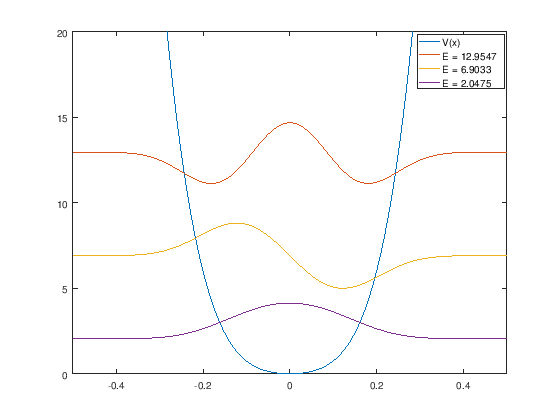

In [6]:
plot_eigs(x, V, eigE, eigfuncs);
xlim([-0.5, 0.5]);
ylim([0, 20]);

In [7]:
[xd, Nd, delta_eigE] = test_sensitivity(5, part1_solver, x0, x1, N, eigE)

xd =

  -0.53587  -0.53002  -0.53240  -0.53486  -0.51705
   0.59938   0.57406   0.51600   0.52407   0.56587

Nd =

   2194   2245   2118   2187   2223

delta_eigE =

  -3.7359e-06   1.5879e-06   9.4649e-07   3.1176e-06   2.5301e-06
  -1.1327e-06   5.0473e-07   3.0653e-07   9.7512e-07   7.9388e-07
  -1.6797e-07   7.5888e-08   4.6295e-08   1.4583e-07   1.1889e-07



The average (even maximum) difference versus eigenvalues computed for these perturbed parameters is smaller than the fifth significant figure of the computed eigenvalues, so I'm confident that I've got the eigenvalues correct to 5 figures.

## Part 2: Asymmetric Potential

In [8]:
V = newV([50, 1500, 2500]);
part2_solver = @(x0, x1, N) tise_fd(V, x0, x1, N, 100, 3);
x0 = -0.9; x1 = 0.5; N = 3000;
[eigE, eigfuncs, x] = part2_solver(x0, x1, N);

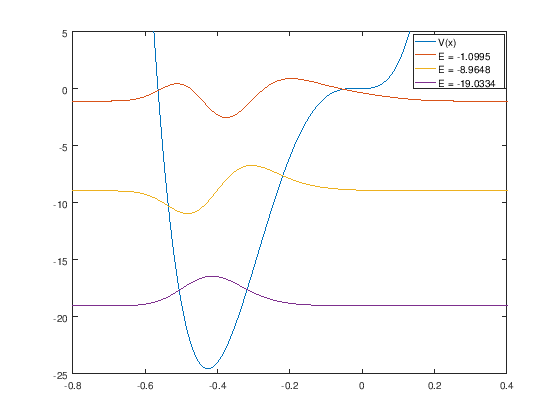

In [9]:
plot_eigs(x, V, eigE, eigfuncs);
xlim([-0.8, 0.4]);
ylim([-25, 5]);

In [10]:
[xd, Nd, delta_eigE] = test_sensitivity(5, part2_solver, x0, x1, N, eigE)

xd =

  -1.02722  -1.02636  -0.99249  -0.94614  -0.97796
   0.53598   0.58071   0.53265   0.56737   0.55343

Nd =

   3465   3216   3451   3283   3302

delta_eigE =

   3.8667e-06  -8.6788e-06   6.0993e-06   1.4211e-06   7.2719e-07
   2.6635e-06  -5.9783e-06   4.2014e-06   9.7890e-07   5.0087e-07
   6.8531e-07  -1.5381e-06   1.0809e-06   2.5180e-07   1.2888e-07



The plotted eigenvalues are insensitive to the parameters $x_0$, $x_1$ and $N$ (ie., $h$) to more than 5 significant figures.

# Finite Differences for Nonlinear ODE

The Thomas-Fermi equation
$$ \sqrt{r} n'' = n^{3/2} $$
discretized to first-order is
$$ \sqrt{r_i} \left( \frac{n_{i+1} - 2 n_i + n_{i-1}}{h^2} \right) = n_i^{3/2}. $$
Rearranging to factor out $n_i$ gives
$$ n_i \left( \sqrt{n_i} + 2 \frac{\sqrt{r_i}}{h^2}\right) = \frac{\sqrt{r_i}}{h^2} \left( n_{i+1} + n_{i-1} \right) $$
and dividing through by $\sqrt{r_i} / h^2$ I obtain
$$ n_i \left(h^2\sqrt{n_i / r_i} + 2\right) = n_{i+1} + n_{i-1}, $$
and thus
$$ n_i = \frac{n_{i+1} + n_{i-1}}{h^2\sqrt{n_i / r_i} + 2}. $$
This form is good for computation, and I'll use it in my Gauss-Seidel algorithm. It agrees with literature upon multiplying the left-hand side by $\frac{\sqrt{r_i} / h^2}{\sqrt{r_i} / h^2}.$

In [11]:
type('thomas_fermi_fd.m')

thomas_fermi_fd.m is the user-defined function defined from: /home/jer/Projects/PHY5340/labs/L6/thomas_fermi_fd.m

function [n, iter, rel_err] = thomas_fermi_fd(n, r, alpha, tol, max_iter)
%adapted from C16_2
N = numel(r);
h = r(2) - r(1);
nn = n;
iter = 0; done = false;
while ~done
    iter = iter + 1;
    if iter > max_iter
        disp('max iteration exceeded')
        break
    end
    for i = [2:N-1]
        % Gauss-Seidel
        n(i) = (nn(i+1) + n(i-1)) / (h^2 * (nn(i) / r(i))^.5 + 2);
        % Over-relaxation
        n(i) = n(i) + alpha * (n(i) - nn(i));
    end
    rel_err = abs((n - nn)./n);
    rel_err(isnan(rel_err)) = 0;
    if all(rel_err < tol)
        done = true;
    end
    nn = n;   
end
end



As an initial guess I'll take $n$ linear between the boundary values 1 and 0 at $r =$ 0 and 100. The Gauss-Siedel method gives the result to a relative tolerance of 1e-5 as plotted below:

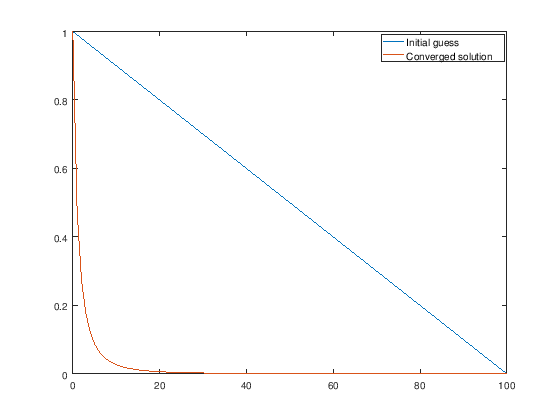

In [12]:
r = linspace(0, 100, 101);
n_init = linspace(1, 0, 101);
plot(r, n_init); hold on;
n = thomas_fermi_fd(n_init, r, 0, 1e-5, 10000);
plot(r, n); hold off;
legend('Initial guess', 'Converged solution')

A good choice of over-relaxation parameter could enable the method to converge faster; I'll plot the number of iterations required for convergence versus the over-relaxation parameter for 20 values below.

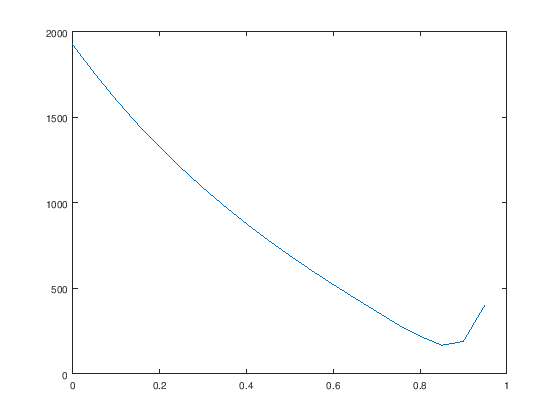

In [13]:
N = 20;
numiter = zeros(1, N);
# want alpha to be N evenly spaced values in [0,1)
# this sort of thing is why FORTRAN indexing sucks
alpha = linspace(0, 1, N+1);
alpha = alpha(1:end-1);
for i = [1:N]
    [~, numiter(i)] = thomas_fermi_fd(n_init, r, alpha(i), 1e-5, 10000);
end
plot(alpha, numiter)

The algorithm converges nearly an order of magnitude faster for a good choice of over-relaxation parameter, but the method slows down in the limit as the parameter approaches 1. I expect it would fail if the parameter were taken too large.